## Ellipsoidal Collapse and Mass Functions

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import seaborn as sns
from tqdm.notebook import tqdm

import jax
import jax.numpy as jnp
from jax import grad
from jaxopt import Bisection
from jax.scipy.special import erfc

from scipy.optimize import curve_fit

from jax.config import config
config.update("jax_enable_x64", True)
plt.style.use("./global_style.mplstyle")

In [2]:
from fuzzylli.interpolation_jax import init_1d_interpolation_params, eval_interp1d

from fdmfilaments.cosmology import (
    E as Ea, 
    D, 
    T_FDM_Hu2000, 
    omega_m, 
    linear_delta_sc_collapse_at, 
    nonlinear_delta_sc_virial_at, 
    smooth_k_W,
    sigma,
    h, om
)
from fdmfilaments.ellipsoidal_collapse import (
    ic, 
    delta, 
    ellipsoidal_collapse_trajectories, 
    dai_da_freeze_out, 
    dai_da_constant_density,
    above_nonlinear_density,
    bond_meyers_freeze_out,
    axis_i_virialized
)

from fuzzylli.units import cgs_units, Units
from fuzzylli.utils import quad
import logging

In [3]:
save_dir="../img"
columnwidth = 244.0/72.27
textwidth = 508.0/72.27
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

In [4]:
H0 = 100 * h * Units.kms / Units.Mpc
rho_m = om * 3 * H0**2 / (8 * np.pi * Units.Grav)

## Figure 9

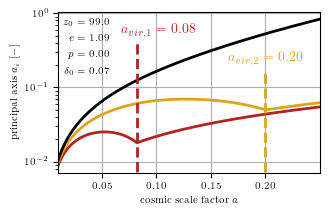

In [5]:
a0 = 0.01
aend = 0.25
avir = 0.2
delta0 = 1.484*D(a0)/D(avir)
e_exp = 1.095
p_exp = 0.0
y0, lambda0 = ic(e_exp, p_exp, a0, delta0)

av, yv, made_jump = ellipsoidal_collapse_trajectories(dai_da_constant_density, 
                                                      axis_i_virialized, 
                                                      y0, a0, aend, lambda0)

fig, ax = plt.subplots(figsize=(columnwidth, 0.618*columnwidth))
ax.set_yscale("log")
colors = ["firebrick", "goldenrod", "black"]
for i in range(3):
    line, = ax.plot(av, yv[i,:],c=colors[i])
    

ax.vlines(x=av[made_jump][0], 
                  ymin=0.0, ymax=0.5*jnp.max(yv[2,:]), color=colors[0], ls="dashed")
ax.text(av[made_jump][0]+0.02, 0.6*jnp.max(yv[2,:])+0.2, 
                rf"$a_{{vir,{1}}}={av[made_jump][0]:.2f}$", 
                transform=ax.transData, 
                fontsize=10, va="top",ha="center", color=colors[0])

ax.vlines(x=av[made_jump][1], 
                  ymin=0.0, ymax=0.2*jnp.max(yv[2,:]), color=colors[1], ls="dashed")
ax.text(av[made_jump][1], 0.3*jnp.max(yv[2,:])+0.04, 
                rf"$a_{{vir,{2}}}={av[made_jump][1]:.2f}$", 
                transform=ax.transData, 
                fontsize=10, va="top",ha="center", color=colors[1])

Mh = 4.0e9 * cgs_units.from_Msun
def Ri2ai(Ri, Mh):
    rho_m_h2 = rho_m / h**2 * cgs_units.from_g/cgs_units.from_cm**3
    R_pk = (3*Mh/(4*jnp.pi*rho_m_h2))**(1/3)* cgs_units.from_Mpc
    return Ri/R_pk

def ai2Ri(ai,Mh):
    rho_m_h2 = rho_m / h**2 * cgs_units.from_g/cgs_units.from_cm**3
    R_pk = (3*Mh/(4*jnp.pi*rho_m_h2))**(1/3)
    return R_pk*ai * cgs_units.to_Mpc

ics = rf"\begin{{align*}}z_0&={1.0/a0 - 1}\\e &= {e_exp:.2f}\\p &= {p_exp:.2f}\\ \delta_0 &= {delta0:.2f}\end{{align*}}"
ax.text(0.02, 0.96, ics, transform=ax.transAxes, ha="left", va="top")

ax.set_xlabel(r"$\mathrm{cosmic\;scale\;factor}\;a$")
ax.set_ylabel(r"$\mathrm{principal\;axis\;}a_i\;[-]$")
plt.subplots_adjust(wspace=0.0, hspace=0.05)
plt.show()
#plt.savefig(f"{save_dir}/collapse_trajectory.pdf", format="PDF", pad_inches=0.02)

In [6]:
def axis_i_bisection(dai_da, freeze_out, e, p, delta0, z0, z, i):
    a0 = 1/(z0+1)
    y0, lambda0 = ic(e, p, a0, delta0)
    aend = 1/(z+1) * 1.4
    a, y, made_jump = ellipsoidal_collapse_trajectories(dai_da, freeze_out, y0, a0, aend, lambda0)
    assert made_jump.sum() >= i

    return a[made_jump][i-1] - 1/(z+1)

In [7]:
def delta_ec_of_e(i, z, z0, dai_da, freeze_out, e, lower, upper):
    p=0.0
    a0 = 1.0/(z0+1)
    a = 1.0/(z+1)
    objective=lambda e, p, delta0, z0, z_vir: axis_i_bisection(dai_da, freeze_out, e, p, delta0, z0, z_vir, i)
    optimize_delta_jaxopt_bisection = lambda delta: objective(e, p, delta, z0, z)
    bisec = Bisection(optimality_fun=optimize_delta_jaxopt_bisection, lower=lower, upper=upper, jit=False)
    return bisec.run().params * D(1/(1+z))/D(1/(1+z0))

In [8]:
a0 = .01
a = 0.2

experiments = {
    "sheth_tormen_filament": {
        "ode_source": dai_da_constant_density,
        "freeze_out": bond_meyers_freeze_out,
        "ellipticity": jnp.linspace(.05, 2, 40),
        "up_to_axis": 2,
        "upper": 2.0*D(a0)/D(a)*linear_delta_sc_collapse_at(a),
        "lower": 0.75*D(a0)/D(a)*linear_delta_sc_collapse_at(a),
        "z":1/a - 1
    },
    "virial_freezeout_constant_density_filaments": {
        "ode_source": dai_da_constant_density,
        "freeze_out": axis_i_virialized,
        "ellipticity": jnp.linspace(0.05, 2.5, 40),
        "up_to_axis": 2,
        "upper": 2.0*D(a0)/D(a)*linear_delta_sc_collapse_at(a),
        "lower": 0.75*D(a0)/D(a)*linear_delta_sc_collapse_at(a),
        "z":1/a - 1
    }
}

In [9]:
experiments["sheth_tormen_filament"]["label"] = r"constant density /freeze-out"
experiments["virial_freezeout_constant_density_filaments"]["label"] = r"constant density /virial"

In [10]:
for name in experiments:
    z = experiments[name]["z"]
    z0 = 99
    linear_delta_ec = [experiments[name]["lower"]* D(1/(1+z))/D(1/(1+z0))]
    lower =  experiments[name]["lower"]
    upper =  experiments[name]["upper"]
    print(f"Running {name}...")
    for i,e in enumerate(tqdm(experiments[name]["ellipticity"])):
        z = experiments[name]["z"]
        z0 = 99
        a = (1+z)**-1
        a0 = (1+z0)**-1
        linear_delta_ec.append(delta_ec_of_e(experiments[name]["up_to_axis"],
                                               experiments[name]["z"],
                                               z0,
                                               experiments[name]["ode_source"], 
                                               experiments[name]["freeze_out"],
                                               e, lower, upper))
        delta_ic = linear_delta_ec[-1] * D(1/(1+z0))/D(1/(1+z))
        # Adjust bisection interval based on whether barrier increases/decreases
        if i>0:
            if linear_delta_ec[-1] > linear_delta_ec[-2]:
                lower = 0.9*delta_ic
                if (upper-lower)/upper < 0.1:
                    upper *= 1.1
            if linear_delta_ec[-1] < linear_delta_ec[-2]:
                upper = 1.1*delta_ic
                if (upper-lower)/upper < 0.1:
                    lower /= 1.1
        
    experiments[name]["delta_ec"] = linear_delta_ec[1:]

Running sheth_tormen_filament...


  0%|          | 0/40 [00:00<?, ?it/s]

Running virial_freezeout_constant_density_filaments...


  0%|          | 0/40 [00:00<?, ?it/s]

In [13]:
p = 0
z0 = 99
z_vir = 4.0
for name in experiments:
    print(f"Running {name}...")
    length_ec = []
    r_ec = []
    source = experiments[name]["ode_source"]
    freeze_out = experiments[name]["freeze_out"]
    for e,d0 in zip(experiments[name]["ellipticity"], experiments[name]["delta_ec"]):
        delta0 = d0 * D(1.0/(1+z0))/D(1.0/(1+z_vir))
        a0 = 1/(z0+1)
        y0, lambda0 = ic(e, p, a0, delta0)
        aend = 1.0/(1+z_vir)
        a, y, made_jump = ellipsoidal_collapse_trajectories(source, freeze_out, y0, a0, aend, lambda0)
        length_ec.append(y[2,jnp.argmin(jnp.abs(a-1.0/(1+z_vir)))])
        r_ec.append(jnp.sqrt(jnp.prod(y[:2,jnp.argmin(jnp.abs(a-1.0/(1+z_vir)))])))
    experiments[name]["length_ec"] = length_ec
    experiments[name]["r_ec"] = r_ec

Running sheth_tormen_filament...
Running virial_freezeout_constant_density_filaments...


In [14]:
for name in experiments:
    e = experiments[name]["ellipticity"]
    experiments[name]["delta_ec_params"] = init_1d_interpolation_params(e[0], 
                                                                         e[1]-e[0], 
                                                                         jnp.array(experiments[name]["delta_ec"]))
    experiments[name]["length_params"] = init_1d_interpolation_params(e[0], 
                                                                      e[1]-e[0], 
                                                                      jnp.array(experiments[name]["length_ec"]))
    experiments[name]["radius_params"] = init_1d_interpolation_params(e[0], 
                                                                      e[1]-e[0], 
                                                                      jnp.array(experiments[name]["r_ec"]))

In [15]:
@partial(jax.vmap, in_axes=(0,None, None, None))
def e_of_S(S, delta_ec_params, lower, upper):
    """
    Ellipticity as funciton of variance according to most probable state of Dobroschkowiz DF (see ST2001)
    """
    def fun(e_mp):
        # ST01 most probable value presecription
        return jnp.sqrt(S)/jnp.sqrt(5) * 1.0/(eval_interp1d(e_mp, delta_ec_params)) - e_mp

    bisec = Bisection(optimality_fun=fun, lower=lower, upper=upper, check_bracket=False)
    return bisec.run().params

def delta_ec_of_S(S, a,b,c):
    return a*S ** b + c

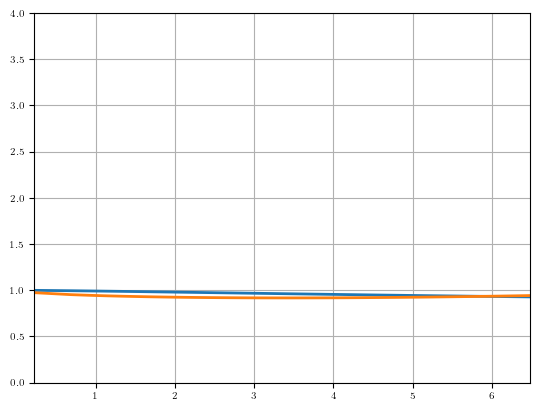

In [16]:
eval = jax.vmap(eval_interp1d, in_axes=(0,None))
S = np.linspace(0.05,42,100)
fig,ax = plt.subplots()
delta_sc_z = linear_delta_sc_collapse_at(a)
for name in experiments:
    ydata = eval(e_of_S(S, experiments[name]["delta_ec_params"], 
                        experiments[name]["ellipticity"][0], 
                        experiments[name]["ellipticity"][-1]-1e-10), 
                 experiments[name]["delta_ec_params"])
    popt_ec2_barrier, _ = curve_fit(delta_ec_of_S, S, ydata)
    experiments[name]["barrier_params"] = popt_ec2_barrier
    ax.plot(np.sqrt(S), ydata/1.618, label=f"{name}")
ax.set_ylim([0,4])
plt.show()

In [17]:
def solve_volterra(k, f,  a, b, num=1000, method="midpoint"):
    sgrid = np.linspace(a + (b - a) / num, b, num)
    ktril = np.tril(k(sgrid[:, np.newaxis], sgrid))
    if method == "midpoint":
        pass
    elif method == "trapezoid":
        # apply trapezoid rule by halving the endpoints
        np.fill_diagonal(ktril, np.diag(ktril) / 2)
        # remember that 0,0 was already halved in the diagonal
        ktril[:, 0] = ktril[:, 0] + k(sgrid, 0) / 2
    sgrid = jnp.asarray(sgrid)
    ktril = jnp.asarray(ktril)
    ggrid = jax.scipy.linalg.solve_triangular(
        ktril, f(sgrid), lower=True, check_finite=False
    )
    # combine the s grid and the g grid
    return sgrid, ggrid * num / (b - a)

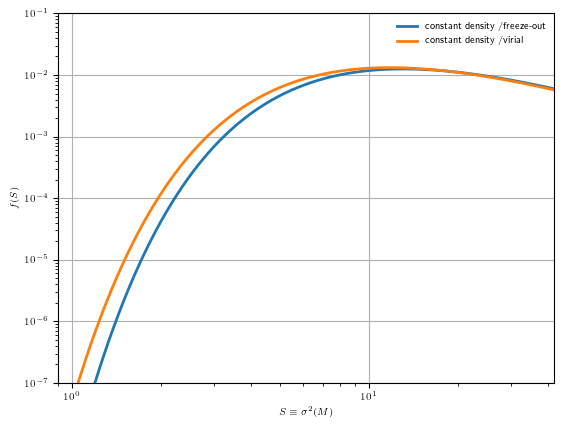

In [18]:
z = 4.0

def K(S,T,B):
    return erfc(jnp.where(jnp.isclose(S,T), 0.0, (B(S) - B(T))/jnp.sqrt(2*(S-T))))
def g(S,B):
    return erfc(B(S)/jnp.sqrt(2*S)) 
    
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_xscale("log")
for name in experiments:
    B_ec2 = lambda S: delta_ec_of_S(S, *experiments[name]["barrier_params"])/(D(1/(z+1))/D(1))
    S, fS = solve_volterra(lambda S,T: K(S,T,B_ec2), lambda S: g(S, B_ec2), 0.05, 42.0, 10000)
    experiments[name]["logfS_ec_params"] = init_1d_interpolation_params(S[0], S[1]-S[0], jnp.log(fS))
    ax.plot(S, fS, label=experiments[name]["label"])

ax.legend(*ax.get_legend_handles_labels())
ax.set_xlabel(r"$S\equiv \sigma^2(M)$")
ax.set_ylabel(r"$f(S)$")
ax.set_ylim([1e-7, .1])
ax.set_xlim([0.9, 42])
plt.show()

## Filament Mass Function

In [19]:
p = Path("../data")
files = sorted(
    list(p.glob("*cdm*matterpower.dat")) + list(p.glob("*fdm*matterpower.dat"))
)
k, P = np.loadtxt(files[0], unpack=True)
k = jnp.asarray(k)
P = jnp.asarray(P)
params_Plogk = init_1d_interpolation_params(
    jnp.log(k[0]), jnp.log(k[1]) - jnp.log(k[0]), P
)

def P_ext(k,a,b):
    return a*k**b
popt_Pk, _ = curve_fit(P_ext, k[-100:],P[-100:])

@jax.jit
def P_k(k):
    return jnp.piecewise(k, 
                         [k<1e4, k>=1e4], 
                         [lambda k: eval_interp1d(jnp.log(k), params_Plogk), 
                          lambda k: P_ext(k, *popt_Pk)])

P_k_m22 = jax.jit(
    lambda k: T_FDM_Hu2000(k, 1.0) ** 2 * P_k(k)
)
P_k_2m22 = jax.jit(
    lambda k: T_FDM_Hu2000(k, 2.0) ** 2 * P_k(k)
)
P_k_4m22 = jax.jit(
    lambda k: T_FDM_Hu2000(k, 4.0) ** 2 * P_k(k)
)
P_k_8m22 = jax.jit(
    lambda k: T_FDM_Hu2000(k, 8.0) ** 2 * P_k(k)
)
P_k_16m22 = jax.jit(
    lambda k: T_FDM_Hu2000(k, 16.0) ** 2 * P_k(k)
)

Ps_k = {
        r"$\mathrm{CDM}$":P_k,
        r"$m_{22}=8$":P_k_8m22,
        r"$m_{22}=4$":P_k_4m22,
        r"$m_{22}=2$":P_k_2m22,
        r"$m_{22}=1$":P_k_m22
       }
label_to_mass = {
    r"$\mathrm{CDM}$":"cdm",
    r"$m_{22}=8$":"8",
    r"$m_{22}=4$":"4",
    r"$m_{22}=2$":"2",
    r"$m_{22}=1$":"1"
}

### Barriers

In [20]:
window = smooth_k_W

def S_M(Mh, P_k_h, window_kR, rho_m_h2):
    """
    Density variance as a function of mass scale
    """
    return sigma(
        window_kR.R(Mh, rho_m_h2) * cgs_units.to_Mpc,
        P_k_h,
        window_kR,
    )**2

dlogS_dlogM = lambda Mh, P_k_h,rho_m_h2: Mh*jax.grad(lambda Mh: jnp.log(S_M(Mh, P_k_h, window, rho_m_h2)))(Mh)
dS_dM = lambda Mh, P_k_h,rho_m_h2: jax.grad(lambda Mh: S_M(Mh, P_k_h, window, rho_m_h2))(Mh)

@partial(jax.vmap, in_axes=(0,None,None,None))
def nu(Mh, z, P_k_h, rho_m_h2):
    delta_sc = 1.686 / (D(1/(1+z))/D(1))
    return (delta_sc**2 / S_M(Mh, P_k_h, window, rho_m_h2))
    
@partial(jax.vmap, in_axes=(0,None,None,None,None,None))
def st_n(Mh,z, P_k_h,alpha, beta, rho_m_h2):
    """
    Mass function
    """
    return rho_m_h2/Mh**2 * st_nu_fnu(nu(Mh,z,P_k_h, rho_m_h2),alpha,beta) * jnp.abs(dlogS_dlogM(Mh,P_k_h, rho_m_h2))

def st_nu_fnu(nu, alpha, beta):
    """
    Seth-Tormen upcrossing distribution nu*f(nu)
    """
    return jnp.sqrt(nu/(2*jnp.pi)) * jnp.exp(-nu/2*(1+beta*nu**-alpha)**2)*(1+beta/nu**alpha*(1-alpha+alpha*(alpha-1)/2))

@partial(jax.vmap, in_axes=(0,None,None,None))
def dndM(Mh, P_k_h, rho_m_h2, logfS_params):
    """
    Mass function
    """
    S = S_M(Mh, P_k_h, window, rho_m_h2)
    return rho_m_h2/Mh * jnp.abs(dS_dM(Mh, P_k_h, rho_m_h2))* jnp.exp(eval_interp1d(S, logfS_params))


@partial(jax.vmap, in_axes=(0,None,None,None,None,None))
def dndM_bounded(Mh, P_k_h, rho_m_h2, logfS_params, Smin, Smax):
    """
    Mass function
    """

    S = S_M(Mh, P_k_h, window, rho_m_h2)
    return jnp.where(jnp.logical_and(S>Smin, S<Smax),
                     rho_m_h2/Mh * jnp.abs(dS_dM(Mh, P_k_h, rho_m_h2))* jnp.exp(eval_interp1d(S, logfS_params)),
                     0)
    

@partial(jax.vmap, in_axes=(0,None,None,None,None))
def n_cumulative(Mh, P_k_h, rho_m_h2, dndM, M_max):
    
    @jax.jit
    def dndlogM(logM):
        Mh = jnp.exp(logM)
        return Mh * dndM(Mh)

    logM_bounds = jnp.log(10 ** jnp.linspace(jnp.log10(Mh), jnp.log10(M_max), 100))
    quads = jax.vmap(quad, in_axes=(None, 0, 0))
    res = jnp.sum(quads(dndlogM, logM_bounds[:-1], logM_bounds[1:]))
    return res


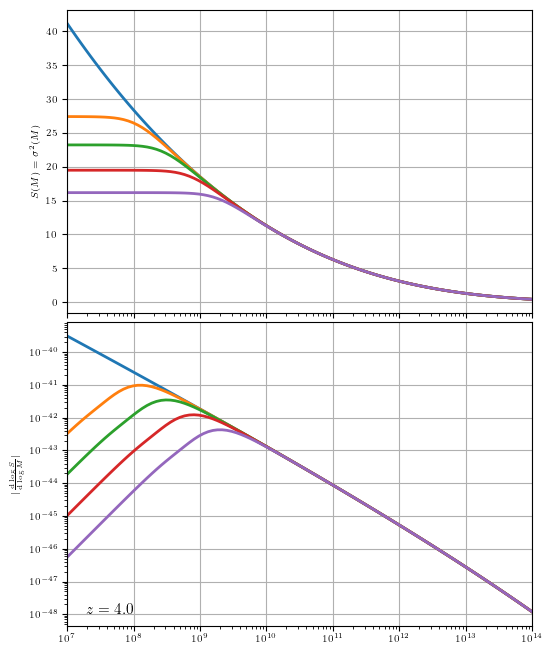

In [21]:
Mh = np.logspace(7,14,100) * cgs_units.from_Msun #Units Msun h^-1
rho_m_h2 = rho_m / h**2 * cgs_units.from_g/cgs_units.from_cm**3

z = 4.0

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6,8))
ax[0].set_xscale("log")
S_M_batch = jax.vmap(S_M, in_axes=(0,None,None,None))
dlogS_dlogM_batch = jax.vmap(dlogS_dlogM, in_axes=(0,None,None))
dS_dM_batch = jax.vmap(dS_dM, in_axes=(0,None,None))

for label, P_k_h in Ps_k.items():
    ax[0].plot(Mh * cgs_units.to_Msun, S_M_batch(Mh, P_k_h, window, rho_m_h2), label=label)
ax[0].set_ylabel(r"$S(M)=\sigma^2(M)$")

ax[1].set_yscale("log")
for label, P_k_h in Ps_k.items():
    ax[1].plot(Mh* cgs_units.to_Msun, np.abs(dS_dM_batch(Mh,P_k_h,rho_m_h2)))
ax[1].set_ylabel(r"$|\frac{\mathrm{d}\log S}{\mathrm{d} \log M}|$")
ax[1].legend(*ax[1].get_legend_handles_labels(), fontsize=10)
ax[1].text(0.04,0.04,rf"$z={z}$", transform=ax[1].transAxes,fontsize=11)
plt.subplots_adjust(wspace=0, hspace=0.03)

plt.show()

In [22]:
from matplotlib.legend_handler import HandlerBase
from matplotlib.lines import Line2D

class StackedLineHandler(HandlerBase):
    def __init__(self, colors, linestyles, linewidths, alphas):
        super().__init__()
        self.colors = colors
        self.linestyles = linestyles
        self.linewidths = linewidths
        self.alphas = alphas

    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        artists = []
        for i, (color, linestyle, linewidth, alpha) in enumerate(zip(self.colors, self.linestyles, self.linewidths, self.alphas)):
            y_position = ydescent + height * (0.75 - 0.5 * i)  # Adjust y positions for stacking
            line = Line2D([xdescent, xdescent + width], [y_position, y_position],
                          color=color, linestyle=linestyle, linewidth=linewidth, alpha=alpha, transform=trans)
            artists.append(line)
        return artists

## Figure 10

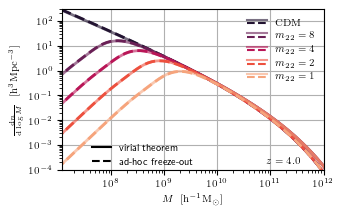

In [23]:
import seaborn as sns
import pickle

fig, ax = plt.subplots(figsize=(columnwidth, 0.618*columnwidth))
ax.set_xscale("log")
ax.set_yscale("log")
colors = sns.color_palette("rocket",10)
names = ["virial_freezeout_constant_density_filaments", "sheth_tormen_filament"]
handles = []
labels = []
handler_map = {}
alphas = [0.6, 1.]
ls = ["solid", "dashed"]

for i, (label, P_k_h) in enumerate(Ps_k.items()):
    for j, name in enumerate(names):
        Smax = min(S_M(Mh[0], P_k_h, window, rho_m_h2), 45)
        n_M = dndM_bounded(Mh, P_k_h,rho_m_h2, experiments[name]["logfS_ec_params"],0.05, Smax) 
        fmf_params = init_1d_interpolation_params(
            jnp.log10(Mh[0]), 
            jnp.log10(Mh[1]) - jnp.log10(Mh[0]),
            n_M
        )
        with open(f"../data/cache/fmf_{label_to_mass[label]}", mode="wb") as file:
            pickle.dump(fmf_params, file)
        line, = ax.plot(Mh* cgs_units.to_Msun, 
                    Mh* n_M* 1/(cgs_units.to_Mpc**3),
                    color = colors[2*i], ls=ls[j], alpha=alphas[j])
    stacked_lines_handle = Line2D([], [])
    handler = StackedLineHandler(
        colors=[colors[2*i], colors[2*i]],
        linestyles=ls,
        linewidths=[1.5, 1.5],
        alphas=alphas
    )

    handles.append(stacked_lines_handle)
    labels.append(label)
    handler_map[stacked_lines_handle] = handler

ax.set_ylabel(r"$\frac{\mathrm{d}n}{\mathrm{d} \log M}\;\;\mathrm{[h^3 Mpc^{-3}]}$")
ax.set_xlabel(r"$M\;\;\mathrm{[h^{-1} M_\odot]}$")
ax.set_ylabel(r"$\frac{\mathrm{d}n}{\mathrm{d}\log M}\;\;\mathrm{[h^3 Mpc^{-3}]}$")
ax.set_xlim([1.2e7, 1e14])

legend = ax.legend(handles=handles,
           labels=labels,
           handler_map=handler_map, loc="upper right")
l1, = ax.plot([],[], c="k", lw=1.5)
l2, = ax.plot([],[], c="k", ls="dashed",lw=1.5)

ax.legend([l1,l2], [r"$\text{virial\;theorem}$",r"$\text{ad-hoc\;freeze-out}$"], bbox_to_anchor=[0.08, -0.03], loc="lower left")
ax.add_artist(legend)

ax.set_ylim([1e-4, 300])    
ax.set_xlim([1.2e7, 1e12])
ax.text(0.78,0.04,rf"$z={z}$", transform=ax.transAxes)
plt.show()
#plt.savefig(f"{save_dir}/filament_mass_function.pdf", format="PDF",bbox_inches="tight", pad_inches=0.01)

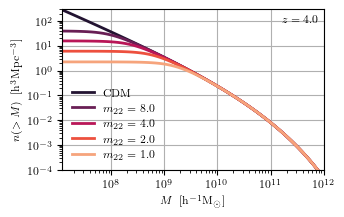

In [210]:
fig, ax = plt.subplots(figsize=(columnwidth, 0.618*columnwidth))
ax.set_xscale("log")
ax.set_yscale("log")

V=1
colors = sns.color_palette("rocket",10)

for i, (label, P_k_h) in enumerate(Ps_k.items()):
    Smax = min(S_M(Mh[0], P_k_h, window, rho_m_h2), 42)
    f = lambda Mh : dndM_bounded(Mh, P_k_h,rho_m_h2, experiments[name]["logfS_ec_params"], 
                                 0.05,
                                 Smax) 
    n_M_full = n_cumulative(Mh, P_k_h, rho_m_h2, f, 1e16*cgs_units.from_Msun) * 1/(cgs_units.to_Mpc**3)
    line, = ax.plot(Mh* cgs_units.to_Msun, V*n_M_full, label=label, color=colors[2*i])

ax.set_xlabel(r"$M\;\;\mathrm{[h^{-1} M_\odot]}$")
ax.set_ylabel(r"$n(>M)\;\;\mathrm{[h^3 Mpc^{-3}]}$")
leg = ax.legend(*ax.get_legend_handles_labels(), loc="lower left")
ax.set_xlim([1.2e7, 1e12])
ax.set_ylim([1e-4, 300])
ax.text(0.84,0.92,rf"$z={z}$", transform=ax.transAxes)
plt.subplots_adjust(wspace=0.06, hspace=0.05)
#plt.savefig(f"{save_dir}/cumulative_filament_mass_function.pdf", format="PDF",bbox_inches="tight", pad_inches=0.03)

### Cylinder Parameters from Ellipsoidal Collapse

In [24]:
def log_power_law_of_M(logM,a,b):
    return b*logM+a

beta=0.0
name = "virial_freezeout_constant_density_filaments"
Mh = np.logspace(7,11,100) * cgs_units.from_Msun #Units Msun h^-1
e_of_Mh = e_of_S(S_M_batch(Mh, P_k_h, window, rho_m_h2), 
                    experiments[name]["delta_ec_params"], 
                    experiments[name]["ellipticity"][0], 
                    experiments[name]["ellipticity"][-1])

l = 2*ai2Ri(eval(e_of_Mh, experiments[name]["length_params"]), Mh)   #Mpc h-1
r = ai2Ri(eval(e_of_Mh, experiments[name]["radius_params"]), Mh) #Mpc h-1
sigma_v = jnp.sqrt((Units.Grav * Mh / ((2-beta) * l* cgs_units.from_Mpc))) * cgs_units.to_kms     #km/s
mu = Mh/(2*ai2Ri(eval(e_of_Mh, experiments[name]["length_params"]), Mh)) * cgs_units.to_Msun     #Msun/Mpc

Smax = min(S_M(Mh[0], P_k_h, window, rho_m_h2), 45)
Smin = 0.05
f = lambda Mh : dndM_bounded(Mh, P_k,rho_m_h2, experiments[name]["logfS_ec_params"], Smin, Smax) 
dn_dM = dndM_bounded(Mh, P_k_h,rho_m_h2, experiments[name]["logfS_ec_params"],Smin, Smax) * 1/(cgs_units.to_Msun*cgs_units.to_Mpc**3)

popt_loglength, _ = curve_fit(log_power_law_of_M, jnp.log(Mh*cgs_units.to_Msun), jnp.log(l))
popt_logsigma_v, _ = curve_fit(log_power_law_of_M, jnp.log(Mh*cgs_units.to_Msun), jnp.log(sigma_v))
popt_logmu, _ = curve_fit(log_power_law_of_M, jnp.log(Mh*cgs_units.to_Msun), jnp.log(mu))
popt_logradius, _ = curve_fit(log_power_law_of_M, jnp.log(Mh*cgs_units.to_Msun), jnp.log(r))

mask = jnp.logical_and(Mh>3e9*cgs_units.from_Msun,Mh<1e11*cgs_units.from_Msun)
popt_logdn_dM, _ = curve_fit(log_power_law_of_M, jnp.log(Mh[mask]*cgs_units.to_Msun), jnp.log(dn_dM[mask]))

print("Powerlaw fit parameters a*M**b for: ")
print("length ",popt_loglength)
print("v_dispersion ",popt_logsigma_v)
print("line mass ",popt_logmu)
print("radius ",popt_logradius)
print("FMF ", popt_logdn_dM)

Powerlaw fit parameters a*M**b for: 
length  [-7.63270221  0.27634879]
v_dispersion  [-6.16244124  0.3618256 ]
line mass  [7.6327022  0.72365121]
radius  [-12.00153483   0.33619234]
FMF  [26.19079996 -2.19428366]
